In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

df_rewards = pd.read_csv('./out/cumulated_reward.csv', index_col=[0, 1])
df_rewards

reward     reward.1     reward.2     reward.3  \
               createdAt                                                        
MABTree Random 2024-10-02    49.558611    42.447143    46.941667    46.140476   
               2024-10-03    83.472925    76.433810    81.811389    86.310198   
               2024-10-04   114.530425   111.397143   114.841389   121.153254   
               2024-10-05   139.098759   142.510198   147.300833   146.066699   
               2024-10-06   173.639949   178.759994   173.343333   175.106778   
...                                ...          ...          ...          ...   
LinUCB         2024-12-18  3393.359197  3393.359197  3393.359197  3393.359197   
               2024-12-19  3438.827609  3438.827609  3438.827609  3438.827609   
               2024-12-20  3478.117054  3478.117054  3478.117054  3478.117054   
               2024-12-21  3511.423602  3511.423602  3511.423602  3511.423602   
               2024-12-22  3552.908403  3552.908403  3552.908403  3552.908403   

                              reward.4     reward.5     reward.6     reward.7  \
               createdAt                                                        
MABTree Random 2024-10-02    48.742290    46.268175    45.772217    52.266437   
               2024-10-03    77.551457    68.713185    83.986820    84.201437   
               2024-10-04   110.256060   104.125615   124.508576   124.010604   
               2024-10-05   136.295941   131.871538   156.131631   156.819485   
               2024-10-06   166.326655   162.375030   188.993298   184.980279   
...                                ...          ...          ...          ...   
LinUCB         2024-12-18  3393.359197  3393.359197  3393.359197  3393.359197   
               2024-12-19  3438.827609  3438.827609  3438.827609  3438.827609   
               2024-12-20  3478.117054  3478.117054  3478.117054  3478.117054   
               2024-12-21  3511.423602  3511.423602  3511.423602  3511.423602   
               2024-12-22  3552.908403  3552.908403  3552.908403  3552.908403   

                              reward.8     reward.9  
               createdAt                             
MABTree Random 2024-10-02    55.792483    49.462907  
               2024-10-03    87.696967    89.395395  
               2024-10-04   122.920362   124.482022  
               2024-10-05   156.119789   155.271189  
               2024-10-06   187.824388   183.944046  
...                                ...          ...  
LinUCB         2024-12-18  3393.359197  3393.359197  
               2024-12-19  3438.827609  3438.827609  
               2024-12-20  3478.117054  3478.117054  
               2024-12-21  3511.423602  3511.423602  
               2024-12-22  3552.908403  3552.908403  

[574 rows x 10 columns]

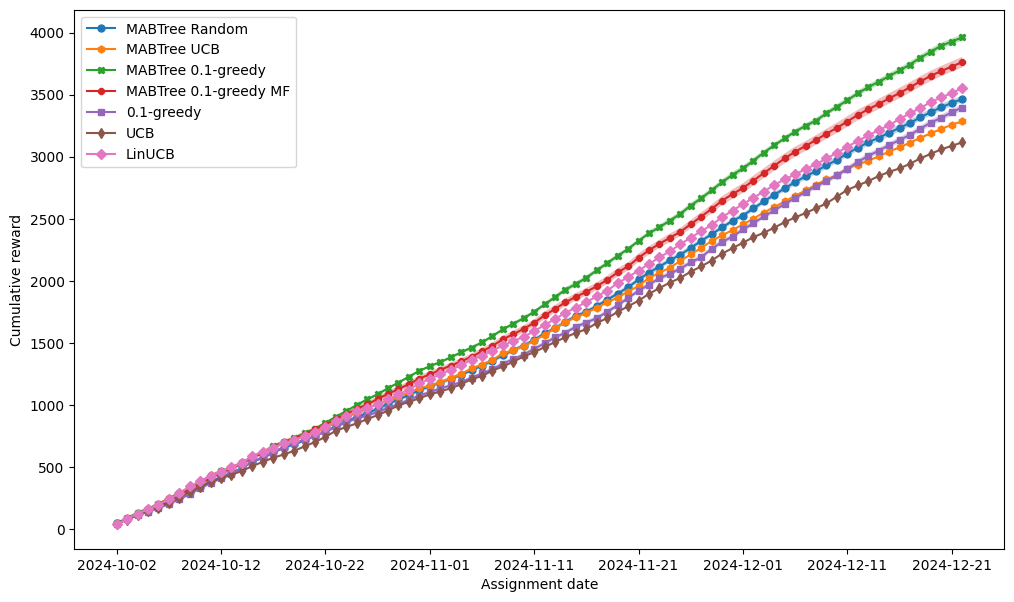

In [2]:
plt.figure(figsize=(12, 7))
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
for marker, (name, group) in zip(['o', 'h', 'X', '8', 's', 'd', 'D'], df_rewards.groupby(level=0, sort=False)):
    m = group.mean(axis=1)
    s = group.std(axis=1)

    CI_min = m - 1.96 * s / group.shape[1] ** 0.5
    CI_max = m + 1.96 * s / group.shape[1] ** 0.5

    plt.plot(group.index.get_level_values(1), m, label=name, marker=marker, markersize=5)
    plt.fill_between(group.index.get_level_values(1), CI_min, CI_max, alpha=0.3)

plt.ylabel('Cumulative reward')
plt.xlabel('Assignment date')
plt.legend()
plt.savefig('./out/cumulative_reward.pdf', format='pdf', bbox_inches='tight')
plt.show()

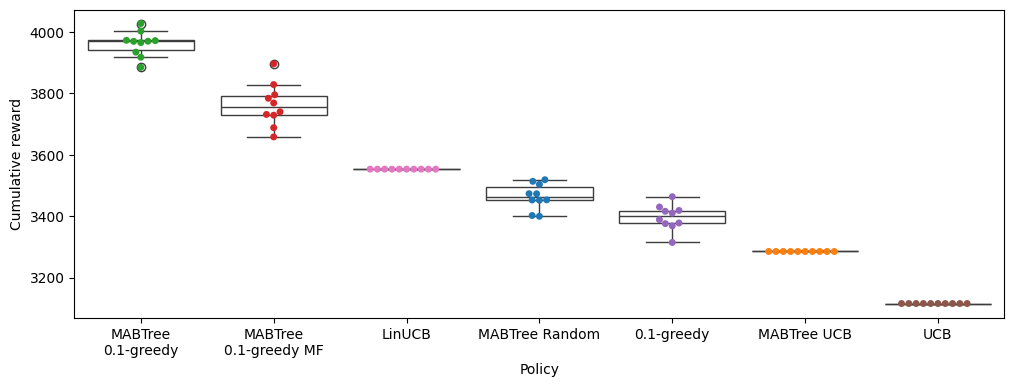

In [3]:
import seaborn as sns
final_cumulative_reward = df_rewards.groupby(level=0, sort=False).last().T
renamed = final_cumulative_reward.rename(columns={
    'MABTree 0.1-greedy': 'MABTree\n0.1-greedy',
    'MABTree 0.1-greedy MF': 'MABTree\n0.1-greedy MF'
})
rank = renamed.median().sort_values(ascending=False).index

plt.figure(figsize=(12, 4))
sns.boxplot(data=renamed, color='white', order=rank)
sns.swarmplot(data=renamed)
plt.ylabel('Cumulative reward')
plt.xlabel('Policy')
plt.savefig('./out/cumulative_reward_2.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [4]:
def highlight_max(s):
    d = s.sort_values(ascending=False)

    style = {
        d.index[0]: 'textbf:--rwrap ;',   # max
        d.index[1]: 'underline:--rwrap ;',  # second max
        d.index[-1]: 'textit:--rwrap ;',  # min
    }

    return [style.get(v, '') for v in s.index]

final_cumulative_reward = final_cumulative_reward.reset_index(drop=True)

final_cumulative_reward \
    .describe().loc[['mean', 'std', 'min', 'max', '50%']].T \
    .style.format('{:.3f}', escape=True).apply(highlight_max, axis=0) \
    .to_latex('./out/cumulative_reward_stats.tex', position='t', position_float='centering', hrules=True, caption='Cumulative reward statistics. The best and second best values of each column are highlighted in bold and underlined, respectively. The worst value is italicized.', label='tab:cumulative_reward_stats')

In [5]:
from scipy import stats


tukey_hsd = pd.DataFrame(
    columns=final_cumulative_reward.columns,
    index=final_cumulative_reward.columns,
    data=stats.tukey_hsd(*[final_cumulative_reward[col] for col in final_cumulative_reward.columns]).pvalue
)

tukey_hsd.map(lambda x: '< 0.01' if x < 0.01 else '< 0.05' if x < 0.05 else 'non stat-sig') \
    .style.to_latex('./out/tukey_hsd.tex', position='t', position_float='centering', hrules=True, caption='Tukey HSD test results. The p-values are reported.', label='tab:tukey_hsd')

# Coverage

In [6]:
df_coverage = pd.read_csv('./out/coverage.csv', index_col=[0])
df_coverage

,MABTree Random,MABTree UCB,MABTree 0.1-greedy,MABTree 0.1-greedy MF,0.1-greedy,UCB,LinUCB
0,0.808412,0.392817,0.334914,0.728258,0.329522,0.443045,0.486934
1,0.806305,0.392817,0.337092,0.725395,0.331770,0.443045,0.486934
2,0.808711,0.392817,0.335230,0.740130,0.331893,0.443045,0.486934
3,0.809782,0.392817,0.336038,0.731542,0.331595,0.443045,0.486934
4,0.809519,0.392817,0.337390,0.716157,0.333351,0.443045,0.486934
5,0.808500,0.392817,0.335722,0.712645,0.330014,0.443045,0.486934
6,0.808360,0.392817,0.336688,0.732929,0.329874,0.443045,0.486934
7,0.805954,0.392817,0.334422,0.712768,0.332069,0.443045,0.486934
8,0.808711,0.392817,0.336407,0.722041,0.329575,0.443045,0.486934
9,0.809343,0.392817,0.337144,0.732631,0.329909,0.443045,0.486934


In [7]:
final_cumulative_reward

,MABTree Random,MABTree UCB,MABTree 0.1-greedy,MABTree 0.1-greedy MF,0.1-greedy,UCB,LinUCB
0,3399.438333,3284.783678,3969.372915,3731.026780,3463.206886,3115.335922,3552.908403
1,3401.957804,3284.783678,4002.451745,3795.036305,3418.398486,3115.335922,3552.908403
2,3452.497142,3284.783678,3965.029909,3657.896661,3368.257321,3115.335922,3552.908403
3,3472.662551,3284.783678,3933.946128,3728.590891,3409.722131,3115.335922,3552.908403
4,3451.738549,3284.783678,3971.391626,3895.832162,3314.170427,3115.335922,3552.908403
5,3452.896947,3284.783678,3917.343701,3783.749763,3415.724329,3115.335922,3552.908403
6,3513.235905,3284.783678,3884.351087,3687.819155,3429.662201,3115.335922,3552.908403
7,3518.376486,3284.783678,3968.989846,3828.239895,3377.501949,3115.335922,3552.908403
8,3503.403612,3284.783678,4027.089623,3739.626983,3388.652829,3115.335922,3552.908403
9,3473.032439,3284.783678,3972.451004,3768.366929,3375.495759,3115.335922,3552.908403


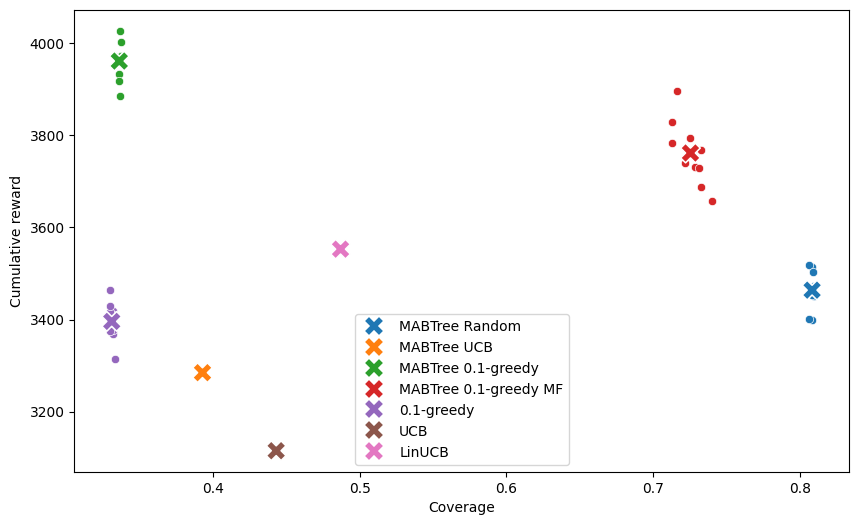

In [8]:
ax = plt.figure(figsize=(10, 6)).gca()
for x, y in zip(df_coverage, final_cumulative_reward):
    sns.scatterplot(x=df_coverage[x], y=final_cumulative_reward[y], ax=ax)
sns.scatterplot(x=df_coverage.mean(axis=0), y=final_cumulative_reward.mean(axis=0), hue=df_coverage.columns, s=200, marker='X', ax=ax)

plt.xlabel('Coverage')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig('./out/cumulative_reward_vs_coverage.pdf', format='pdf')
plt.show()

# Intra user diversity

In [9]:
df_diversity = pd.read_csv('./out/diversity.csv', index_col=[0])
df_diversity

,MABTree Random,MABTree UCB,MABTree 0.1-greedy,MABTree 0.1-greedy MF,0.1-greedy,UCB,LinUCB
0,4.660346,4.003464,2.721020,4.173157,2.630268,4.109575,4.007061
1,4.656254,4.003464,2.741046,4.196786,2.635142,4.109575,4.007061
2,4.656587,4.003464,2.720216,4.244791,2.601789,4.109575,4.007061
3,4.657882,4.003464,2.708073,4.206143,2.588471,4.109575,4.007061
4,4.655668,4.003464,2.714915,4.173883,2.615030,4.109575,4.007061
5,4.659095,4.003464,2.710502,4.160810,2.618983,4.109575,4.007061
6,4.656744,4.003464,2.716245,4.225101,2.613171,4.109575,4.007061
7,4.657603,4.003464,2.705628,4.186119,2.621523,4.109575,4.007061
8,4.658883,4.003464,2.756876,4.180387,2.600671,4.109575,4.007061
9,4.659045,4.003464,2.701800,4.201906,2.599661,4.109575,4.007061


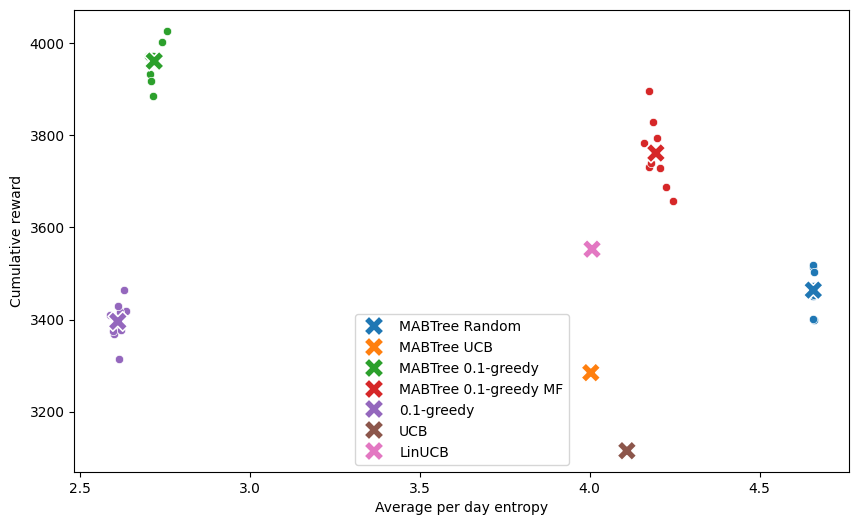

In [10]:
ax = plt.figure(figsize=(10, 6)).gca()
for x, y in zip(df_diversity, final_cumulative_reward):
    sns.scatterplot(x=df_diversity[x], y=final_cumulative_reward[y], ax=ax)
sns.scatterplot(x=df_diversity.mean(axis=0), y=final_cumulative_reward.mean(axis=0), hue=df_diversity.columns, s=200, marker='X', ax=ax)

plt.xlabel('Average per day entropy')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig('./out/cumulative_reward_vs_entropy.pdf', format='pdf')
plt.show()